In [1]:
from sklearn.metrics import accuracy_score
import pandas as pd
# Assuming both DataFrames are aligned (i.e., corresponding rows match correctly)
# If not, you may need to align them first.

In [2]:
df1=pd.read_csv('/Users/md.rafiulbiswas/Documents/Ozempic/Evaluation/facebook_500_WA.csv')

In [4]:
df2=pd.read_csv('/Users/md.rafiulbiswas/Documents/Ozempic/Evaluation/reddit_1000_WA.csv')

In [5]:
len(df1), len(df2)

(501, 999)

In [10]:
print(df1.columns),print(df2.columns)

Index(['id', 'text', 'sentiment_human', 'Efficacy', 'SideEffect', 'Cost',
       'Stigma and community Reactions', 'sentiment_predicted',
       'sentiment_negative', 'sentiment_neutral', 'sentiment_positive'],
      dtype='object')
Index(['id', 'text', 'sentiment_human', 'Efficacy', 'SideEffect', 'Cost',
       'Stigma and community Reactions', 'sentiment_predicted',
       'sentiment_negative', 'sentiment_neutral', 'sentiment_positive'],
      dtype='object')


(None, None)

In [7]:
df1.rename(columns={"Facebook Id": "id", "Seniment_human":"sentiment_human"}, inplace = True)
df2.rename(columns={"Seniment":"sentiment_human","sentiment_label":"sentiment_predicted"}, inplace = True)

In [9]:
df1.drop(['Unnamed: 0','Note'], axis=1, inplace=True)
df2.drop(['Unnamed: 0','date'], axis=1, inplace=True)

In [13]:
df=pd.concat([df1, df2])

In [15]:
len(df)

1500

In [14]:
df.head(2)

,id,text,sentiment_human,Efficacy,SideEffect,Cost,Stigma and community Reactions,sentiment_predicted,sentiment_negative,sentiment_neutral,sentiment_positive
0,100059000000000.0,only 13% of employees at ozempic maker novo no...,Neutral,none,none,none,none,Negative,0.707492,0.271344,0.021164
1,100064000000000.0,rick ho-ho-horowitz leads carolers through geo...,Negative,none,types of side effects,none,none,Negative,0.608637,0.370687,0.020676


In [16]:
df.to_csv('/Users/md.rafiulbiswas/Documents/Ozempic/Evaluation/human_annotation.csv')

In [67]:
filtered_df=pd.read_csv('/Users/md.rafiulbiswas/Documents/Ozempic/Evaluation/human_annotation.csv')

In [68]:
import random

# Function to resolve the sentiment_human column
def resolve_sentiment(row):
    human_sentiments = row['sentiment_human']
    predicted_sentiment = row['sentiment_predicted']

    # Check if there are two values
    if isinstance(human_sentiments, list) and len(human_sentiments) == 2:
        # Keep the one matching predicted_sentiment, if exists
        if predicted_sentiment in human_sentiments:
            return predicted_sentiment
        else:
            # Randomly pick one if no match
            return random.choice(human_sentiments)
    return human_sentiments  # Return as-is if there's one value or unexpected structure

# Ensure sentiment_human is converted to a list for proper handling
filtered_df['sentiment_human'] = filtered_df['sentiment_human'].apply(
    lambda x: x if isinstance(x, list) else [x]  # Ensure list structure
)

# Apply the resolve_sentiment function
filtered_df['sentiment_human'] = filtered_df.apply(resolve_sentiment, axis=1)

In [69]:
# Keep only rows where 'sentiment' is not null
filtered_df = df[df['sentiment_human'].notnull()]

# Optionally, reset the index
filtered_df = filtered_df.reset_index(drop=True)

In [70]:
len(filtered_df)

750

In [71]:
# Count the number of rows where 'sentiment_human' has two values
num_rows_two_values = filtered_df['sentiment_predicted'].apply(lambda x: len(x) == 2 if isinstance(x, list) else False).sum()

print(f"Number of rows with two values: {num_rows_two_values}")


Number of rows with two values: 0


In [72]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
)

# Calculate accuracy
accuracy = accuracy_score(filtered_df['sentiment_human'], filtered_df['sentiment_predicted'])

# Calculate precision, recall, and F1-score
precision = precision_score(filtered_df['sentiment_human'], filtered_df['sentiment_predicted'], average='weighted')
recall = recall_score(filtered_df['sentiment_human'], filtered_df['sentiment_predicted'], average='weighted')
f1 = f1_score(filtered_df['sentiment_human'], filtered_df['sentiment_predicted'], average='weighted')

# Macro F1-Score (already included in 'macro' F1 calculation above)
macro_f1 = f1  # Alias for clarity

# Calculate AUC (only applicable for binary classification or multi-class with probabilities)
try:
    auc = roc_auc_score(
        pd.get_dummies(filtered_df['sentiment_human']),
        pd.get_dummies(filtered_df['sentiment_predicted']),
        average='macro',
        multi_class='ovo'
    )
except ValueError:
    auc = None  # If AUC can't be computed (e.g., discrete predictions for non-binary cases)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision (Macro): {precision:.2f}")
print(f"Recall (Macro): {recall:.2f}")
print(f"F1-Score (Macro): {f1:.2f}")
if auc is not None:
    print(f"AUC (Macro): {auc:.2f}")
else:
    print("AUC: Not applicable for the current predictions.")

# Optional: Detailed classification report
print("\nClassification Report:")
print(classification_report(filtered_df['sentiment_human'], filtered_df['sentiment_predicted']))



Accuracy: 0.75
Precision (Macro): 0.75
Recall (Macro): 0.75
F1-Score (Macro): 0.75
AUC (Macro): 0.66

Classification Report:
                    precision    recall  f1-score   support

          Negative       0.83      0.75      0.79       268
 Negative, Neutral       0.00      0.00      0.00         1
Negative, Positive       0.00      0.00      0.00         1
           Neutral       0.62      0.73      0.67       218
 Neutral, Negative       0.00      0.00      0.00         1
 Neutral, Positive       0.00      0.00      0.00         1
          Positive       0.80      0.78      0.79       259
Positive, Negative       0.00      0.00      0.00         1

          accuracy                           0.75       750
         macro avg       0.28      0.28      0.28       750
      weighted avg       0.75      0.75      0.75       750



/Users/md.rafiulbiswas/miniconda3/envs/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/md.rafiulbiswas/miniconda3/envs/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/md.rafiulbiswas/miniconda3/envs/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

              precision    recall  f1-score   support

    Negative       0.84      0.75      0.79       268
     Neutral       0.62      0.72      0.67       221
    Positive       0.80      0.78      0.79       259

    accuracy                           0.75       748
   macro avg       0.75      0.75      0.75       748
weighted avg       0.76      0.75      0.75       748



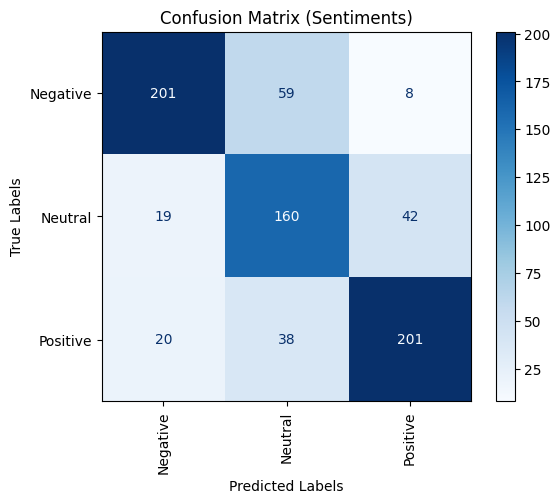

In [81]:
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

def simplify_sentiment(sentiment):
    """Simplifies combined sentiment labels to single labels."""
    if isinstance(sentiment, str): #check if it is string to prevent error when it is nan
        if "," in sentiment:
            sentiments = [s.strip() for s in sentiment.split(",")]
            # Logic for handling combined labels. You might need to adjust this based on your specific needs.
            if "Neutral" in sentiments:
                return "Neutral"  # Prioritize Neutral
            elif "Positive" in sentiments and "Negative" not in sentiments:
                return "Positive"
            elif "Negative" in sentiments and "Positive" not in sentiments:
                return "Negative"
            else:
                return np.nan # or any other label that makes sense for your data
        else:
            return sentiment
    return np.nan # return nan if the value is not a string

# Assuming filtered_df is already loaded
filtered_df['sentiment_human_simplified'] = filtered_df['sentiment_human'].apply(simplify_sentiment)
filtered_df = filtered_df.dropna(subset=['sentiment_human_simplified']) # Drop rows with NaN values after simplification

true_labels = filtered_df['sentiment_human_simplified']
predicted_labels = filtered_df['sentiment_predicted']

# Filter out rows where predicted_labels is also combined.
filtered_df['sentiment_predicted_simplified'] = filtered_df['sentiment_predicted'].apply(simplify_sentiment)
filtered_df = filtered_df.dropna(subset=['sentiment_predicted_simplified']) # Drop rows with NaN values after simplification
predicted_labels = filtered_df['sentiment_predicted_simplified']

# Generate the confusion matrix using the simplified labels
labels = sorted(true_labels.unique()) # Get the unique labels after simplification
cm = confusion_matrix(true_labels, predicted_labels, labels=labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', xticks_rotation='vertical')
disp.ax_.set_title("Confusion Matrix (Sentiments)")
disp.ax_.set_xlabel("Predicted Labels")
disp.ax_.set_ylabel("True Labels")
#plt.show()
plt.savefig('/Users/md.rafiulbiswas/Documents/Ozempic/Evaluation/sentiment_confusion.png', bbox_inches='tight')
# Evaluate Metrics using the simplified labels
from sklearn.metrics import classification_report
print(classification_report(true_labels, predicted_labels, labels=labels))

Micro-average AUC: 0.81
AUC for class Negative: 0.83
AUC for class Neutral: 0.77
AUC for class Positive: 0.84


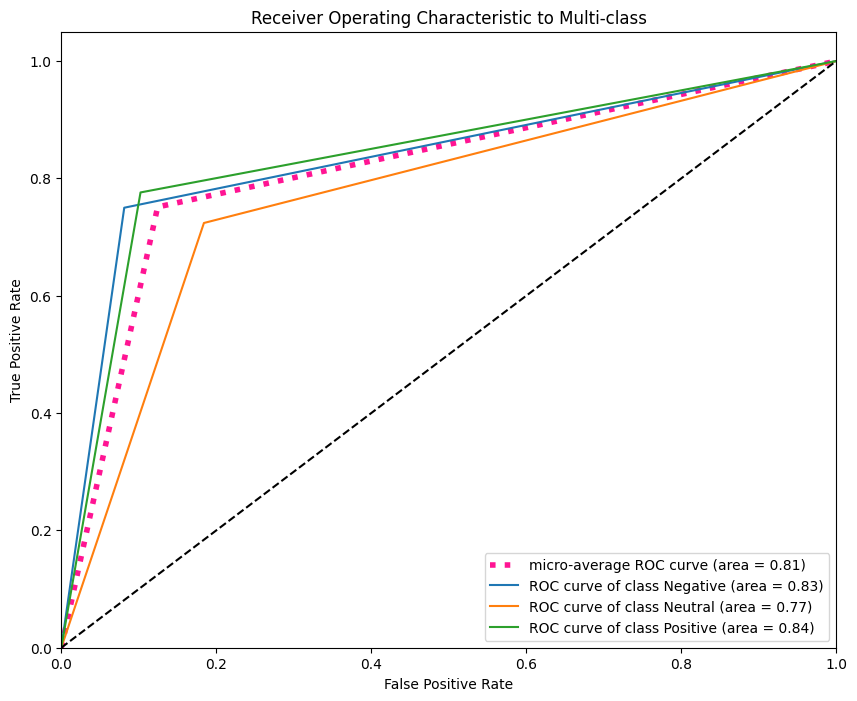

In [82]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer

def simplify_sentiment(sentiment):
    """Simplifies combined sentiment labels to single labels, ignoring 'Mixed'."""
    if isinstance(sentiment, str):
        if "," in sentiment:
            sentiments = [s.strip() for s in sentiment.split(",")]
            if "Neutral" in sentiments:
                return "Neutral"
            elif "Positive" in sentiments and "Negative" not in sentiments:
                return "Positive"
            elif "Negative" in sentiments and "Positive" not in sentiments:
                return "Negative"
            else:
                return np.nan  # Return NaN to ignore mixed cases
        else:
            return sentiment
    return np.nan

# Assuming filtered_df is already loaded
filtered_df['sentiment_human_simplified'] = filtered_df['sentiment_human'].apply(simplify_sentiment)
filtered_df = filtered_df.dropna(subset=['sentiment_human_simplified'])

true_labels = filtered_df['sentiment_human_simplified']

filtered_df['sentiment_predicted_simplified'] = filtered_df['sentiment_predicted'].apply(simplify_sentiment)
filtered_df = filtered_df.dropna(subset=['sentiment_predicted_simplified'])
predicted_labels = filtered_df['sentiment_predicted_simplified']

# Binarize labels
lb = LabelBinarizer()
true_labels_bin = lb.fit_transform(true_labels)
predicted_labels_bin = lb.transform(predicted_labels) # Use transform after fitting on true labels


n_classes = true_labels_bin.shape[1]

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    try:
        fpr[i], tpr[i], _ = roc_curve(true_labels_bin[:, i], predicted_labels_bin[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    except ValueError: # Handle cases where only one class is present
        print(f"Only one class present for label {lb.classes_[i]}. AUC is undefined.")
        roc_auc[i] = np.nan
        continue

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(true_labels_bin.ravel(), predicted_labels_bin.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

for i in range(n_classes):
    if not np.isnan(roc_auc[i]): # Only plot if AUC is defined
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                       ''.format(lb.classes_[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic to Multi-class')
plt.legend(loc="lower right")
plt.savefig('/Users/md.rafiulbiswas/Documents/Ozempic/Evaluation/sentiment_auc.png', bbox_inches='tight')


# Print AUC values
print("Micro-average AUC: {:.2f}".format(roc_auc["micro"]))
for i in range(n_classes):
    if not np.isnan(roc_auc[i]):
        print(f"AUC for class {lb.classes_[i]}: {roc_auc[i]:.2f}")